In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import winsound
import datetime
import optuna
import random

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/datasets")
os.chdir("C:/diego_tools/labo3/dataset")
####################################################

In [3]:
arch_sellout_train = "emp3_sellout_product_train.csv"
arch_min_max_prod = "emp3_min_max_prod.csv"
arch_mean_std_prod = "emp3_mean_std_prod.csv"
arch_prod_ids_prediccion = "productos_a_predecir.csv"
arch_predicciones_full = "emp3_lightgbm_prediccion_full.csv"
arch_predicciones_simple = "emp3_lightgbm_prediccion.csv"

In [4]:
tipos_transf = ['sin_transformacion', 'normalizacion', 'estandarizacion']
GLOBAL_TRANSF = tipos_transf[0]
CANT_ITERACIONES_OPT_BAY = 30
CANT_SEMILLAS = 20

#MAX_BIN_PARAM=255
MAX_BIN_PARAM=1023

GLOBAL_PRODUCT_IDS = pd.DataFrame() #aca solamente se define, se setea mas abajo

In [5]:
# Marco en train, holdout y descartar para considerarlo en las transformaciones
periodo_inicio=201701 #inclusive
train_periodo_limite = 201810 #inclusive
validate_periodo = 201812
train_all_periodo_limite = 201812 #inclusive
holdout_periodo = 201902

In [6]:
########### NORMALIZACION
def normalizar_valor(valor,minimo,maximo):
    if np.isnan(minimo):
        return valor #si no hay minimo, devuelvo valor original (no tener minimo significa que no habia datos en train)
    else:
        if (maximo-minimo)==0: 
            return 0
        else:
            return (valor - minimo) / (maximo-minimo)

        
def desnormalizar_valor(valor,minimo,maximo):
    if np.isnan(minimo):
        return valor #si no hay minimo, devuelvo valor original (no tener minimo significa que no habia datos en train)
    else:
        return (valor * (maximo-minimo)) + minimo

def normalizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=train_periodo_limite) & (df_param.periodo >= periodo_inicio)]
    df_train = df_train[["product_id","tn"]]
    
    #Calculo min max por producto y lo guardo para poder revertir posteriormente
    df_min_max_prod = df_train.groupby('product_id')['tn'].agg(['max', 'min']).reset_index()
    df_min_max_prod = df_min_max_prod.rename(columns={"min":"valor_1","max":"valor_2"})
    df_min_max_prod.to_csv(arch_min_max_prod, index=False)
        
    df_ret = df_param.merge(df_min_max_prod,how="left",on="product_id") #puede haber productos que no aparezcan, por eso left
    
    # Selecciono columnas a normalizar
    
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn
    
    # Dropeo algunas (para evitar ruido)
    cols_remover = ["cust_request_tn","dif_cust_request_tn","cust_request_qty"]
    cols_remover.extend([col for col in df_ret.columns if "cat1_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat2_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat3_" in col])
        
    df_ret = df_ret.drop(columns=cols_remover)  
    
    # Normalizo tn, lags y deltas
    lag_cols = [col for col in df_ret.columns if "lag" in col]
    delta_cols = [col for col in df_ret.columns if "delta" in col]
    cols_norm = ["tn","tn_mas_2"]
    cols_norm.extend(lag_cols)
    cols_norm.extend(delta_cols)
                    
    for col_norm in cols_norm:
        df_ret[col_norm] =df_ret.apply(lambda row: normalizar_valor(row[col_norm],row["valor_1"],row["valor_2"]),axis=1)
    
    return df_ret

############# ESTANDARIZACION
def estandarizar_valor(valor,media,desvio):
    if np.isnan(media):
        return valor #si no hay media, devuelvo valor original (no tener media significa que no habia datos en train)
    else:
        if desvio==0: 
            return 0
        else:
            return (valor - media) / desvio

def desestandarizar_valor(valor,media,desvio):
    if np.isnan(media):
        return valor #si no hay media, devuelvo valor original (no tener media significa que no habia datos en train)
    else:
        return (valor * desvio) + media
    
def estandarizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=train_periodo_limite) & (df_param.periodo >= periodo_inicio)]
    df_train = df_train[["product_id","tn"]]
    
    #Calculo media y desvio por producto y lo guardo para poder revertir posteriormente
    df_mean_std_prod = df_train.groupby('product_id')['tn'].agg(['mean', lambda x: np.std(x,ddof=0)]).reset_index() #se usa ddof=0 para evitar NaN cuando hay un solo producto
    df_mean_std_prod.columns = ["product_id",'valor_1', 'valor_2']
    df_mean_std_prod.to_csv(arch_mean_std_prod, index=False)
        
    df_ret = df_param.merge(df_mean_std_prod,how="left",on="product_id")
    
    # Selecciono columnas a estandarizar
    
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn
    
    # Dropeo algunas (para evitar ruido)
    cols_remover = ["cust_request_tn","dif_cust_request_tn","cust_request_qty"]
    cols_remover.extend([col for col in df_ret.columns if "cat1_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat2_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat3_" in col])
        
    df_ret = df_ret.drop(columns=cols_remover)  
    
    # Estandarizo tn, lags y deltas
    lag_cols = [col for col in df_ret.columns if "lag" in col]
    delta_cols = [col for col in df_ret.columns if "delta" in col]
    cols_norm = ["tn","tn_mas_2"]
    cols_norm.extend(lag_cols)
    cols_norm.extend(delta_cols)
                    
    for col_norm in cols_norm:
        df_ret[col_norm] =df_ret.apply(lambda row: estandarizar_valor(row[col_norm],row["valor_1"],row["valor_2"]),axis=1)
    
    return df_ret

################### TRANSFORMACION    
def transformar_valor(valor,var1,var2):
    if GLOBAL_TRANSF=="normalizacion":
        return normalizar_valor(valor,var1,var2)
    elif GLOBAL_TRANSF=="estandarizacion":
        return estandarizar_valor(valor,var1,var2)
    else:
        return valor

def destransformar_valor(valor,var1,var2):
    if GLOBAL_TRANSF=="normalizacion":
        return desnormalizar_valor(valor,var1,var2)
    elif GLOBAL_TRANSF=="estandarizacion":
        return desestandarizar_valor(valor,var1,var2)
    else:
        return valor

def graficar_ejemplo_transformacion(df_param):
    df_param = df_param[df_param.product_id==20001]
    
    plt.plot(df_param.tn_original)
    plt.title("Original")
    plt.show()
    
    plt.plot(df_param.tn)
    plt.title("Transformado")
    plt.show()

In [7]:
def semillerio(lgbtrain_all, lgb_params, best_iteration, X_holdout, y_holdout):
    er_holdout_list = []
    y_pred_holdout_list = []

    for i in range(0,CANT_SEMILLAS):
        seed = random.randint(1,99999999999999)
        lgb_params_new = {**lgb_params, **{"seed":seed}}

        final_model = lgb.train(lgb_params_new, lgbtrain_all, num_boost_round=best_iteration)

        y_pred_holdout = final_model.predict(X_holdout)
        er_holdout = error_rate(y_holdout,y_pred_holdout)

        y_pred_holdout_list.append(y_pred_holdout)
        er_holdout_list.append(er_holdout)

    #min(er_holdout_list),max(er_holdout_list),round(np.mean(er_holdout_list),2),round(np.median(er_holdout_list),2), round(np.std(er_holdout_list),2)
    y_pred_holdout_semillerio = np.sum(y_pred_holdout_list,axis=0)/CANT_SEMILLAS
    er_holdout_semillerio = error_rate(y_holdout,y_pred_holdout_semillerio)
    return er_holdout_semillerio

In [8]:
############ DEFINO Vector Global de Productos #################
def actualizar_global_prods(y_vector):
    # Ademas del id y los valores para "destransformar", se deja el tn original porque la destransformacion puede no ser
    # precisa para productos que no estaban en train
    GLOBAL_PRODUCT_IDS = pd.DataFrame(data={"product_id":X_holdout.product_id, "tn_orig":np.array(y_vector)})
    GLOBAL_PRODUCT_IDS = GLOBAL_PRODUCT_IDS.merge(df_prod_val1_val2,how="left",on="product_id")
    GLOBAL_PRODUCT_IDS = GLOBAL_PRODUCT_IDS.sort_values(by="product_id",ascending=True)
    
    return GLOBAL_PRODUCT_IDS

In [9]:
def error_rate(y, y_pred):
    y_pred = np.array(y_pred)
    
    #Solamente destransformo la prediccion (para el y tomo el original de la columna tn_orig)
    df_calculo = GLOBAL_PRODUCT_IDS.copy()
    df_calculo["y_pred"] = y_pred
    df_calculo["y_pred_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y_pred"],row["valor_1"],row["valor_2"]),axis=1)

    y = df_calculo.tn_orig
    y_pred = df_calculo.y_pred_destransformado
    
    #Las predicciones negativas se convierten a 0
    y_pred = np.maximum(y_pred, 0)
    
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    return round(100*dif_abs/suma_real,2)

def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = error_rate(labels,preds)
    return 'ER', ret_val, False

In [10]:
def destransformar_vector(y_vector):
    df_calculo = GLOBAL_PRODUCT_IDS.copy()
    df_calculo["y"] = y_vector
    df_calculo["y_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y"],row["valor_1"],row["valor_2"]),axis=1)

    return df_calculo.y_destransformado

In [11]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

In [12]:
##############################################

In [13]:
df_sellout = pd.read_csv(arch_sellout_train)

In [14]:
df_sellout.head()

,product_id,periodo,imputado,tn,cust_request_tn,cust_request_qty,plan_precios_cuidados,periodo_fecha,mes,meses_historia,cat1,cat2,cat3,brand,sku_size,producto_estrella,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe,dif_cust_request_tn,dif_cust_request_tn_porc,tn_lag_1,tn_lag_2,tn_lag_3,tn_lag_4,tn_lag_5,tn_lag_6,tn_lag_7,tn_lag_8,tn_lag_9,tn_lag_10,tn_lag_11,tn_lag_12,tn_lag_13,tn_lag_14,tn_lag_15,tn_mas_2,tn_delta_1,tn_delta_2,tn_delta_3,tn_delta_4,tn_delta_5,tn_delta_6,tn_delta_7,tn_delta_8,tn_delta_9,tn_delta_10,tn_delta_11,tn_delta_12,tn_delta_13,tn_delta_14,tn_delta_15,cat1_tn,cat1_tn_lag_1,cat1_tn_delta_1,cat1_tn_lag_2,cat1_tn_delta_2,cat1_tn_lag_3,cat1_tn_delta_3,cat1_tn_lag_4,cat1_tn_delta_4,cat1_tn_lag_5,cat1_tn_delta_5,cat1_tn_lag_6,cat1_tn_delta_6,cat1_tn_lag_7,cat1_tn_delta_7,cat1_tn_lag_8,cat1_tn_delta_8,cat1_tn_lag_9,cat1_tn_delta_9,cat1_tn_lag_10,cat1_tn_delta_10,cat1_tn_lag_11,cat1_tn_delta_11,cat1_tn_lag_12,cat1_tn_delta_12,cat1_tn_lag_13,cat1_tn_delta_13,cat1_tn_lag_14,cat1_tn_delta_14,cat1_tn_lag_15,cat1_tn_delta_15,cat2_tn,cat2_tn_lag_1,cat2_tn_delta_1,cat2_tn_lag_2,cat2_tn_delta_2,cat2_tn_lag_3,cat2_tn_delta_3,cat2_tn_lag_4,cat2_tn_delta_4,cat2_tn_lag_5,cat2_tn_delta_5,cat2_tn_lag_6,cat2_tn_delta_6,cat2_tn_lag_7,cat2_tn_delta_7,cat2_tn_lag_8,cat2_tn_delta_8,cat2_tn_lag_9,cat2_tn_delta_9,cat2_tn_lag_10,cat2_tn_delta_10,cat2_tn_lag_11,cat2_tn_delta_11,cat2_tn_lag_12,cat2_tn_delta_12,cat2_tn_lag_13,cat2_tn_delta_13,cat2_tn_lag_14,cat2_tn_delta_14,cat2_tn_lag_15,cat2_tn_delta_15,cat3_tn,cat3_tn_lag_1,cat3_tn_delta_1,cat3_tn_lag_2,cat3_tn_delta_2,cat3_tn_lag_3,cat3_tn_delta_3,cat3_tn_lag_4,cat3_tn_delta_4,cat3_tn_lag_5,cat3_tn_delta_5,cat3_tn_lag_6,cat3_tn_delta_6,cat3_tn_lag_7,cat3_tn_delta_7,cat3_tn_lag_8,cat3_tn_delta_8,cat3_tn_lag_9,cat3_tn_delta_9,cat3_tn_lag_10,cat3_tn_delta_10,cat3_tn_lag_11,cat3_tn_delta_11,cat3_tn_lag_12,cat3_tn_delta_12,cat3_tn_lag_13,cat3_tn_delta_13,cat3_tn_lag_14,cat3_tn_delta_14,cat3_tn_lag_15,cat3_tn_delta_15
0,20001,201701,0,934.77,937.73,479.00,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,ARIEL,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,2.95,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1303.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20304.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11153.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3871.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20002,201701,0,550.16,555.19,391.00,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,LIMPIEX,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,5.03,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,834.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20304.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11153.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3871.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20009,201701,0,378.08,380.53,429.00,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,ROPEX1,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,2.45,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20304.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11153.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3871.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [15]:
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23173 entries, 0 to 23172
Columns: 148 entries, product_id to cat3_tn_delta_15
dtypes: bool(1), float64(137), int64(5), object(5)
memory usage: 26.0+ MB


In [16]:
df_sellout.isna().sum()

product_id              0
periodo                 0
imputado                0
tn                      0
cust_request_tn         0
                    ...  
cat3_tn_delta_13    11508
cat3_tn_lag_14      12456
cat3_tn_delta_14    12456
cat3_tn_lag_15      13397
cat3_tn_delta_15    13397
Length: 148, dtype: int64

In [17]:
df_prods_prediccion=pd.read_csv(arch_prod_ids_prediccion)
df_prods_prediccion.head()

,product_id
0,20480
1,20481
2,20482
3,20483
4,20484


In [18]:
df_prods_prediccion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   product_id  868 non-null    int64
dtypes: int64(1)
memory usage: 6.9 KB


In [19]:
# Antes de transformar, se guardan los y_validate y holdout originales (se van a usar en el vector global)
# Esto se debe a que la "destransformacion" no siempre es perfecta, considerando productos que no estuvieron en train
df_sellout_validate_orig = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion.product_id)) & (df_sellout.periodo==validate_periodo)]
df_sellout_validate_orig = df_sellout_validate_orig.sort_values(by="product_id",ascending=True)
y_validate_orig = df_sellout_validate_orig.tn_mas_2
print(len(y_validate_orig))

df_sellout_holdout_orig = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion.product_id)) & (df_sellout.periodo==holdout_periodo)]
df_sellout_holdout_orig = df_sellout_holdout_orig.sort_values(by="product_id",ascending=True)
y_holdout_orig = df_sellout_holdout_orig.tn_mas_2
print(len(y_holdout_orig))

868
868


In [20]:
if GLOBAL_TRANSF == "sin_transformacion":
    print("Sin Transformacion")
     # Dropeo algunas (para evitar ruido)
    cols_remover = ["cust_request_tn","dif_cust_request_tn","cust_request_qty"]
    cols_remover.extend([col for col in df_sellout.columns if "cat1_" in col])
    cols_remover.extend([col for col in df_sellout.columns if "cat2_" in col])
    cols_remover.extend([col for col in df_sellout.columns if "cat3_" in col])
        
    df_sellout_transf = df_sellout.drop(columns=cols_remover)  
        
    df_prod_val1_val2 = pd.DataFrame(data={"product_id":df_sellout.product_id.unique()})
    df_prod_val1_val2["valor_1"]=0
    df_prod_val1_val2["valor_2"]=0
    
elif GLOBAL_TRANSF == "normalizacion":
    print("Normalizacion")
    print(len(df_sellout))
    df_sellout_transf = normalizar_tn(df_sellout)
    print(len(df_sellout_transf))

    graficar_ejemplo_transformacion(df_sellout_transf)
    df_sellout_transf = df_sellout_transf.drop(columns=["tn_original","valor_1","valor_2"])
    
    df_prod_val1_val2 = pd.read_csv(arch_min_max_prod)

elif GLOBAL_TRANSF == "estandarizacion":
    print("Estandarizacion")
    df_sellout_transf = estandarizar_tn(df_sellout)
    graficar_ejemplo_transformacion(df_sellout_transf)
    df_sellout_transf = df_sellout_transf.drop(columns=["tn_original","valor_1","valor_2"])
   
    df_prod_val1_val2 = pd.read_csv(arch_mean_std_prod)
    
df_sellout_transf.head()

Sin Transformacion


,product_id,periodo,imputado,tn,plan_precios_cuidados,periodo_fecha,mes,meses_historia,cat1,cat2,cat3,brand,sku_size,producto_estrella,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe,dif_cust_request_tn_porc,tn_lag_1,tn_lag_2,tn_lag_3,tn_lag_4,tn_lag_5,tn_lag_6,tn_lag_7,tn_lag_8,tn_lag_9,tn_lag_10,tn_lag_11,tn_lag_12,tn_lag_13,tn_lag_14,tn_lag_15,tn_mas_2,tn_delta_1,tn_delta_2,tn_delta_3,tn_delta_4,tn_delta_5,tn_delta_6,tn_delta_7,tn_delta_8,tn_delta_9,tn_delta_10,tn_delta_11,tn_delta_12,tn_delta_13,tn_delta_14,tn_delta_15
0,20001,201701,0,934.77,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,ARIEL,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1303.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20002,201701,0,550.16,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,LIMPIEX,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,834.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20009,201701,0,378.08,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,ROPEX1,3000.00,1.00,25.65,30.40,20.90,1.60,15.91,False,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20015,201701,0,304.25,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,ROPEX1,800.00,0.00,25.65,30.40,20.90,1.60,15.91,False,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20026,201701,0,184.40,0.00,2017-01-01,1,0,HC,ROPA LAVADO,Liquido,LIMPIEX,800.00,0.00,25.65,30.40,20.90,1.60,15.91,False,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
## Se verifica transformacion
df_test = df_sellout_transf[["product_id","periodo","tn","tn_mas_2","tn_lag_1","tn_delta_1"]].merge(df_prod_val1_val2,how="left",on="product_id")
df_test["tn"]=df_test.apply(lambda row: destransformar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_mas_2"]=df_test.apply(lambda row: destransformar_valor(row["tn_mas_2"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_lag_1"]=df_test.apply(lambda row: destransformar_valor(row["tn_lag_1"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_delta_1"]=df_test.apply(lambda row: destransformar_valor(row["tn_delta_1"],row["valor_1"],row["valor_2"]),axis=1)
df_test = df_test.merge(df_sellout[["product_id","periodo","tn","tn_mas_2","tn_lag_1","tn_delta_1"]],how="inner",on=["product_id","periodo"])
df_test[["product_id","periodo","tn_x","tn_y","tn_mas_2_x","tn_mas_2_y","tn_lag_1_x","tn_lag_1_y","tn_delta_1_x","tn_delta_1_y"]].head()

,product_id,periodo,tn_x,tn_y,tn_mas_2_x,tn_mas_2_y,tn_lag_1_x,tn_lag_1_y,tn_delta_1_x,tn_delta_1_y
0,20001,201701,934.77,934.77,1303.36,1303.36,NaN,NaN,NaN,NaN
1,20002,201701,550.16,550.16,834.74,834.74,NaN,NaN,NaN,NaN
2,20009,201701,378.08,378.08,456.07,456.07,NaN,NaN,NaN,NaN
3,20015,201701,304.25,304.25,462.48,462.48,NaN,NaN,NaN,NaN
4,20026,201701,184.40,184.40,259.71,259.71,NaN,NaN,NaN,NaN


In [22]:
# Compruebo que no haya diferencias
df_test["dif"]=df_test.tn_x-df_test.tn_y
df_test[df_test.dif>1e-3]

,product_id,periodo,tn_x,tn_mas_2_x,tn_lag_1_x,tn_delta_1_x,valor_1,valor_2,tn_y,tn_mas_2_y,tn_lag_1_y,tn_delta_1_y,dif


In [23]:
df_test[df_test.tn_x.isna()]

,product_id,periodo,tn_x,tn_mas_2_x,tn_lag_1_x,tn_delta_1_x,valor_1,valor_2,tn_y,tn_mas_2_y,tn_lag_1_y,tn_delta_1_y,dif


In [24]:
#Transformo todas las categoricas
categories = ["plan_precios_cuidados","cat1","cat2","cat3","product_id"]

for c in categories: 
    df_sellout_transf[c] = df_sellout_transf[c].astype("category")   
    
#Elimino otras variables
df_sellout_transf = df_sellout_transf.drop(columns=["brand","periodo_fecha","imputado"])

In [25]:
df_train = df_sellout_transf[(df_sellout_transf.periodo <= train_periodo_limite) & (df_sellout_transf.periodo >= periodo_inicio)]
df_validate = df_sellout_transf[df_sellout_transf.periodo == validate_periodo]

df_train_all = df_sellout_transf[(df_sellout_transf.periodo <= train_all_periodo_limite) & (df_sellout_transf.periodo >= periodo_inicio)]
df_holdout = df_sellout_transf[df_sellout_transf.periodo == holdout_periodo]
# En validate y en test deben quedar 868 productos (son los productos a predecir)

#En validate dejamos unicamente los productos a predecir
print(len(df_validate))
df_validate = df_validate[df_validate.product_id.isin(df_prods_prediccion.product_id)]
df_validate = df_validate.sort_values(by="product_id",ascending=True)
print(len(df_validate))

#Idem holdout
print(len(df_holdout))
df_holdout = df_holdout[df_holdout.product_id.isin(df_prods_prediccion.product_id)]
df_holdout = df_holdout.sort_values(by="product_id",ascending=True)
print(len(df_holdout))

df_train.periodo.unique(),df_validate.periodo.unique(),df_train_all.periodo.unique(),df_holdout.periodo.unique()

1051
868
1055
868


(array([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708,
        201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804,
        201805, 201806, 201807, 201808, 201809, 201810], dtype=int64),
 array([201812], dtype=int64),
 array([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708,
        201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804,
        201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812],
       dtype=int64),
 array([201902], dtype=int64))

In [26]:
# Train - Validate
X_train = df_train.drop(columns=["tn_mas_2","periodo"], axis=1)
X_validate = df_validate.drop(columns=["tn_mas_2","periodo"], axis=1)

y_train = df_train.tn_mas_2
y_validate = df_validate.tn_mas_2

# Train All - Holdout
X_train_all = df_train_all.drop(columns=["tn_mas_2","periodo"], axis=1)
X_holdout = df_holdout.drop(columns=["tn_mas_2","periodo"], axis=1)

y_train_all = df_train_all.tn_mas_2
y_holdout = df_holdout.tn_mas_2

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nX_validate:", X_validate.shape)
print("y_validate:", y_validate.shape)

print("\nX_train_all:", X_train_all.shape)
print("y_train_all:", y_train_all.shape)

print("\nX_holdout:", X_holdout.shape)
print("y_holdout:", y_holdout.shape)

X_train: (20016, 47)
y_train: (20016,)

X_validate: (868, 47)
y_validate: (868,)

X_train_all: (22118, 47)
y_train_all: (22118,)

X_holdout: (868, 47)
y_holdout: (868,)


In [27]:
cols = X_train.columns.tolist()

In [28]:
def objective(trial):

    lgb_params = {
        'objective': 'regression', 
        'first_metric_only': True,
        'boost_from_average': True,
        'max_depth':-1,
        'lambda_l1': 0.0,
        'lambda_l2': 0.0,
        'min_gain_to_split':0.0,
        'force_row_wise':True,
        'feature_pre_filter':False,
        'metric': "None",
        'max_bin': MAX_BIN_PARAM,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.05,0.1,0.2,0.5,0.9]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'feature_fraction': trial.suggest_categorical('feature_fraction', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        'bagging_fraction': trial.suggest_categorical('bagging_fraction',[0.7,0.75,0.8,0.85,0.9,0.95]),
        'extra_trees':trial.suggest_categorical('extra_trees',[True,False]),
        'verbose':-100,
        'num_threads':-1
    }
    
    lgb_params_num_boost_round = 10000  #un numero muy grande, lo limita early_stopping_rounds
    lgb_params_early_stopping_rounds = int(50 + 5/lgb_params['learning_rate']) #  #el parametro discolo, que depende de otro
    
    lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
    lgb_validate = lgb.Dataset(data=X_validate, label=y_validate, reference=lgb_train, feature_name=cols)
    
    #Train using selected parameters
    model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_validate],
                  num_boost_round=lgb_params_num_boost_round,
                  early_stopping_rounds=lgb_params_early_stopping_rounds,
                  feval=lgbm_error_rate,
                  verbose_eval=100)
    
    y_pred_validate =model.predict(X_validate) #Create predictions on test set
    er_validate = error_rate(y_validate,y_pred_validate)
    
    GLOBAL_PARAMS_ITER.append(lgb_params)
    GLOBAL_BEST_IT_ITER.append(model.best_iteration)
    GLOBAL_ER_VALIDATE_ITER.append(er_validate)
    GLOBAL_MODEL_ITER.append(model)
    
    return er_validate

In [29]:
#Antes de entrenar, se setea vector global para validate
GLOBAL_PRODUCT_IDS = actualizar_global_prods(y_validate_orig)

GLOBAL_PARAMS_ITER = []
GLOBAL_BEST_IT_ITER = []
GLOBAL_ER_VALIDATE_ITER = []
GLOBAL_MODEL_ITER = []

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=CANT_ITERACIONES_OPT_BAY)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-11-24 19:12:26,829] A new study created in memory with name: no-name-d0b28ded-5a0e-49a9-abaa-4cca1e96ab0b


Training until validation scores don't improve for 150 rounds
[100]	valid_0's ER: 23.05
[200]	valid_0's ER: 22.91
[300]	valid_0's ER: 23.09
Early stopping, best iteration is:
[153]	valid_0's ER: 22.53
Evaluated only: ER


[I 2023-11-24 19:12:38,646] Trial 0 finished with value: 22.53 and parameters: {'learning_rate': 0.05, 'num_leaves': 261, 'feature_fraction': 0.7, 'min_data_in_leaf': 71, 'bagging_freq': 5, 'bagging_fraction': 0.7, 'extra_trees': False}. Best is trial 0 with value: 22.53.


Training until validation scores don't improve for 150 rounds
[100]	valid_0's ER: 22.64
[200]	valid_0's ER: 22.83


[I 2023-11-24 19:12:51,748] Trial 1 finished with value: 22.21 and parameters: {'learning_rate': 0.05, 'num_leaves': 235, 'feature_fraction': 0.7, 'min_data_in_leaf': 65, 'bagging_freq': 9, 'bagging_fraction': 0.85, 'extra_trees': False}. Best is trial 1 with value: 22.21.


Early stopping, best iteration is:
[135]	valid_0's ER: 22.21
Evaluated only: ER
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ER: 26.72


[I 2023-11-24 19:13:04,034] Trial 2 finished with value: 26.07 and parameters: {'learning_rate': 0.1, 'num_leaves': 433, 'feature_fraction': 0.9, 'min_data_in_leaf': 2, 'bagging_freq': 3, 'bagging_fraction': 0.75, 'extra_trees': False}. Best is trial 1 with value: 22.21.


Early stopping, best iteration is:
[38]	valid_0's ER: 26.07
Evaluated only: ER
Training until validation scores don't improve for 60 rounds
[100]	valid_0's ER: 32.05


[I 2023-11-24 19:13:07,785] Trial 3 finished with value: 29.64 and parameters: {'learning_rate': 0.5, 'num_leaves': 303, 'feature_fraction': 0.5, 'min_data_in_leaf': 41, 'bagging_freq': 4, 'bagging_fraction': 0.75, 'extra_trees': True}. Best is trial 1 with value: 22.21.


Early stopping, best iteration is:
[47]	valid_0's ER: 29.64
Evaluated only: ER
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ER: 28.03
[200]	valid_0's ER: 26.9
[300]	valid_0's ER: 27.59


[I 2023-11-24 19:13:16,607] Trial 4 finished with value: 26.65 and parameters: {'learning_rate': 0.1, 'num_leaves': 892, 'feature_fraction': 0.3, 'min_data_in_leaf': 64, 'bagging_freq': 5, 'bagging_fraction': 0.8, 'extra_trees': True}. Best is trial 1 with value: 22.21.


Early stopping, best iteration is:
[239]	valid_0's ER: 26.65
Evaluated only: ER
Training until validation scores don't improve for 55 rounds


[I 2023-11-24 19:13:19,078] Trial 5 finished with value: 36.77 and parameters: {'learning_rate': 0.9, 'num_leaves': 554, 'feature_fraction': 1.0, 'min_data_in_leaf': 51, 'bagging_freq': 8, 'bagging_fraction': 0.7, 'extra_trees': True}. Best is trial 1 with value: 22.21.


Early stopping, best iteration is:
[6]	valid_0's ER: 36.77
Evaluated only: ER
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ER: 24.8
[200]	valid_0's ER: 24.42
Early stopping, best iteration is:
[198]	valid_0's ER: 24.34
Evaluated only: ER


[I 2023-11-24 19:13:35,134] Trial 6 finished with value: 24.34 and parameters: {'learning_rate': 0.1, 'num_leaves': 582, 'feature_fraction': 1.0, 'min_data_in_leaf': 34, 'bagging_freq': 7, 'bagging_fraction': 0.95, 'extra_trees': True}. Best is trial 1 with value: 22.21.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's ER: 25.96
Early stopping, best iteration is:
[93]	valid_0's ER: 25.65
Evaluated only: ER


[I 2023-11-24 19:13:51,356] Trial 7 finished with value: 25.65 and parameters: {'learning_rate': 0.1, 'num_leaves': 909, 'feature_fraction': 0.8, 'min_data_in_leaf': 12, 'bagging_freq': 5, 'bagging_fraction': 0.9, 'extra_trees': True}. Best is trial 1 with value: 22.21.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 53.08
[200]	valid_0's ER: 28.65
[300]	valid_0's ER: 22.91
[400]	valid_0's ER: 22.02
[500]	valid_0's ER: 21.71
[600]	valid_0's ER: 21.56
[700]	valid_0's ER: 21.72
[800]	valid_0's ER: 21.88
[900]	valid_0's ER: 22.11
[1000]	valid_0's ER: 22.26
[1100]	valid_0's ER: 22.43
Early stopping, best iteration is:
[612]	valid_0's ER: 21.54
Evaluated only: ER


[I 2023-11-24 19:14:56,021] Trial 8 finished with value: 21.54 and parameters: {'learning_rate': 0.01, 'num_leaves': 425, 'feature_fraction': 1.0, 'min_data_in_leaf': 65, 'bagging_freq': 1, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 8 with value: 21.54.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's ER: 25.28


[I 2023-11-24 19:15:10,092] Trial 9 finished with value: 24.26 and parameters: {'learning_rate': 0.1, 'num_leaves': 484, 'feature_fraction': 0.8, 'min_data_in_leaf': 15, 'bagging_freq': 9, 'bagging_fraction': 0.75, 'extra_trees': False}. Best is trial 8 with value: 21.54.


Early stopping, best iteration is:
[42]	valid_0's ER: 24.26
Evaluated only: ER
Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 53.32
[200]	valid_0's ER: 31
[300]	valid_0's ER: 26.42
[400]	valid_0's ER: 25.32
[500]	valid_0's ER: 24.73
[600]	valid_0's ER: 24.42
[700]	valid_0's ER: 24.12
[800]	valid_0's ER: 23.95
[900]	valid_0's ER: 23.8
[1000]	valid_0's ER: 23.69
[1100]	valid_0's ER: 23.69
[1200]	valid_0's ER: 23.72
[1300]	valid_0's ER: 23.77
[1400]	valid_0's ER: 23.81
[1500]	valid_0's ER: 23.87
[1600]	valid_0's ER: 23.91


[I 2023-11-24 19:15:41,097] Trial 10 finished with value: 23.66 and parameters: {'learning_rate': 0.01, 'num_leaves': 12, 'feature_fraction': 0.4, 'min_data_in_leaf': 98, 'bagging_freq': 1, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 8 with value: 21.54.


Early stopping, best iteration is:
[1114]	valid_0's ER: 23.66
Evaluated only: ER
Training until validation scores don't improve for 75 rounds


[I 2023-11-24 19:15:45,587] Trial 11 finished with value: 22.55 and parameters: {'learning_rate': 0.2, 'num_leaves': 114, 'feature_fraction': 0.7, 'min_data_in_leaf': 78, 'bagging_freq': 10, 'bagging_fraction': 0.85, 'extra_trees': False}. Best is trial 8 with value: 21.54.


[100]	valid_0's ER: 25.17
Early stopping, best iteration is:
[28]	valid_0's ER: 22.55
Evaluated only: ER
Training until validation scores don't improve for 150 rounds
[100]	valid_0's ER: 22.59
[200]	valid_0's ER: 22.58
[300]	valid_0's ER: 22.81


[I 2023-11-24 19:15:59,969] Trial 12 finished with value: 22.41 and parameters: {'learning_rate': 0.05, 'num_leaves': 692, 'feature_fraction': 0.6, 'min_data_in_leaf': 89, 'bagging_freq': 1, 'bagging_fraction': 0.85, 'extra_trees': False}. Best is trial 8 with value: 21.54.


Early stopping, best iteration is:
[164]	valid_0's ER: 22.41
Evaluated only: ER
Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 52.68
[200]	valid_0's ER: 28.13
[300]	valid_0's ER: 22.68
[400]	valid_0's ER: 21.45
[500]	valid_0's ER: 21.46
[600]	valid_0's ER: 21.63
[700]	valid_0's ER: 21.72
[800]	valid_0's ER: 21.93
[900]	valid_0's ER: 22.06
Early stopping, best iteration is:
[441]	valid_0's ER: 21.32
Evaluated only: ER


[I 2023-11-24 19:16:54,690] Trial 13 finished with value: 21.32 and parameters: {'learning_rate': 0.01, 'num_leaves': 265, 'feature_fraction': 0.7, 'min_data_in_leaf': 53, 'bagging_freq': 7, 'bagging_fraction': 0.85, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 52.8
[200]	valid_0's ER: 28.67
[300]	valid_0's ER: 23.39
[400]	valid_0's ER: 22.24
[500]	valid_0's ER: 21.97
[600]	valid_0's ER: 22.07
[700]	valid_0's ER: 22.26
[800]	valid_0's ER: 22.44
[900]	valid_0's ER: 22.65
[1000]	valid_0's ER: 22.79
Early stopping, best iteration is:
[518]	valid_0's ER: 21.87
Evaluated only: ER


[I 2023-11-24 19:18:08,910] Trial 14 finished with value: 21.87 and parameters: {'learning_rate': 0.01, 'num_leaves': 368, 'feature_fraction': 1.0, 'min_data_in_leaf': 54, 'bagging_freq': 7, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 52.89
[200]	valid_0's ER: 28.09
[300]	valid_0's ER: 23.28
[400]	valid_0's ER: 22.26
[500]	valid_0's ER: 22.17
[600]	valid_0's ER: 22.52
[700]	valid_0's ER: 22.65
[800]	valid_0's ER: 22.79
[900]	valid_0's ER: 22.92
[1000]	valid_0's ER: 23.09
Early stopping, best iteration is:
[479]	valid_0's ER: 22.14
Evaluated only: ER


[I 2023-11-24 19:19:27,304] Trial 15 finished with value: 22.14 and parameters: {'learning_rate': 0.01, 'num_leaves': 712, 'feature_fraction': 0.6, 'min_data_in_leaf': 33, 'bagging_freq': 3, 'bagging_fraction': 0.9, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 52.47
[200]	valid_0's ER: 29.58
[300]	valid_0's ER: 24.36
[400]	valid_0's ER: 22.79
[500]	valid_0's ER: 22.68
[600]	valid_0's ER: 22.72
[700]	valid_0's ER: 22.62
[800]	valid_0's ER: 22.61
[900]	valid_0's ER: 22.63
[1000]	valid_0's ER: 22.6
[1100]	valid_0's ER: 22.66
[1200]	valid_0's ER: 22.77
[1300]	valid_0's ER: 22.78
[1400]	valid_0's ER: 22.92
[1500]	valid_0's ER: 22.96
[1600]	valid_0's ER: 23.03
Early stopping, best iteration is:
[1063]	valid_0's ER: 22.55
Evaluated only: ER


[I 2023-11-24 19:20:22,933] Trial 16 finished with value: 22.55 and parameters: {'learning_rate': 0.01, 'num_leaves': 162, 'feature_fraction': 0.3, 'min_data_in_leaf': 80, 'bagging_freq': 7, 'bagging_fraction': 0.8, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 52.83
[200]	valid_0's ER: 28.05
[300]	valid_0's ER: 22.68
[400]	valid_0's ER: 21.77
[500]	valid_0's ER: 21.76
[600]	valid_0's ER: 22
[700]	valid_0's ER: 22.17
[800]	valid_0's ER: 22.29
[900]	valid_0's ER: 22.38
Early stopping, best iteration is:
[424]	valid_0's ER: 21.72
Evaluated only: ER


[I 2023-11-24 19:21:17,498] Trial 17 finished with value: 21.72 and parameters: {'learning_rate': 0.01, 'num_leaves': 671, 'feature_fraction': 0.4, 'min_data_in_leaf': 45, 'bagging_freq': 2, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 60 rounds


[I 2023-11-24 19:21:19,375] Trial 18 finished with value: 25.84 and parameters: {'learning_rate': 0.5, 'num_leaves': 25, 'feature_fraction': 0.5, 'min_data_in_leaf': 57, 'bagging_freq': 6, 'bagging_fraction': 0.85, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Early stopping, best iteration is:
[7]	valid_0's ER: 25.84
Evaluated only: ER
Training until validation scores don't improve for 75 rounds


[I 2023-11-24 19:21:27,683] Trial 19 finished with value: 22.75 and parameters: {'learning_rate': 0.2, 'num_leaves': 349, 'feature_fraction': 0.9, 'min_data_in_leaf': 26, 'bagging_freq': 3, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Early stopping, best iteration is:
[20]	valid_0's ER: 22.75
Evaluated only: ER
Training until validation scores don't improve for 55 rounds


[I 2023-11-24 19:21:30,672] Trial 20 finished with value: 29.53 and parameters: {'learning_rate': 0.9, 'num_leaves': 421, 'feature_fraction': 0.7, 'min_data_in_leaf': 80, 'bagging_freq': 6, 'bagging_fraction': 0.85, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Early stopping, best iteration is:
[2]	valid_0's ER: 29.53
Evaluated only: ER
Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 52.82
[200]	valid_0's ER: 28.03
[300]	valid_0's ER: 22.72
[400]	valid_0's ER: 21.74
[500]	valid_0's ER: 21.76
[600]	valid_0's ER: 21.99
[700]	valid_0's ER: 22.12
[800]	valid_0's ER: 22.17
[900]	valid_0's ER: 22.29
Early stopping, best iteration is:
[433]	valid_0's ER: 21.68
Evaluated only: ER


[I 2023-11-24 19:22:25,616] Trial 21 finished with value: 21.68 and parameters: {'learning_rate': 0.01, 'num_leaves': 694, 'feature_fraction': 0.4, 'min_data_in_leaf': 44, 'bagging_freq': 2, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 52.71
[200]	valid_0's ER: 28.45
[300]	valid_0's ER: 22.9
[400]	valid_0's ER: 21.8
[500]	valid_0's ER: 21.47
[600]	valid_0's ER: 21.56
[700]	valid_0's ER: 21.72
[800]	valid_0's ER: 21.84
[900]	valid_0's ER: 21.92
[1000]	valid_0's ER: 22.09
Early stopping, best iteration is:
[515]	valid_0's ER: 21.42
Evaluated only: ER


[I 2023-11-24 19:23:15,385] Trial 22 finished with value: 21.42 and parameters: {'learning_rate': 0.01, 'num_leaves': 808, 'feature_fraction': 0.4, 'min_data_in_leaf': 61, 'bagging_freq': 2, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 52.72
[200]	valid_0's ER: 28.56
[300]	valid_0's ER: 22.92
[400]	valid_0's ER: 21.9
[500]	valid_0's ER: 21.58
[600]	valid_0's ER: 21.68
[700]	valid_0's ER: 21.81
[800]	valid_0's ER: 21.93
[900]	valid_0's ER: 22.04
[1000]	valid_0's ER: 22.18
Early stopping, best iteration is:
[514]	valid_0's ER: 21.54
Evaluated only: ER


[I 2023-11-24 19:24:02,326] Trial 23 finished with value: 21.54 and parameters: {'learning_rate': 0.01, 'num_leaves': 813, 'feature_fraction': 0.4, 'min_data_in_leaf': 61, 'bagging_freq': 1, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 53.16
[200]	valid_0's ER: 28.78
[300]	valid_0's ER: 23.06
[400]	valid_0's ER: 21.92
[500]	valid_0's ER: 21.52
[600]	valid_0's ER: 21.4
[700]	valid_0's ER: 21.56
[800]	valid_0's ER: 21.69
[900]	valid_0's ER: 21.87
[1000]	valid_0's ER: 22.07
[1100]	valid_0's ER: 22.22
Early stopping, best iteration is:
[615]	valid_0's ER: 21.37
Evaluated only: ER


[I 2023-11-24 19:25:17,138] Trial 24 finished with value: 21.37 and parameters: {'learning_rate': 0.01, 'num_leaves': 975, 'feature_fraction': 1.0, 'min_data_in_leaf': 68, 'bagging_freq': 2, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 52.74
[200]	valid_0's ER: 28.5
[300]	valid_0's ER: 22.88
[400]	valid_0's ER: 22.07
[500]	valid_0's ER: 21.67
[600]	valid_0's ER: 21.64
[700]	valid_0's ER: 21.64
[800]	valid_0's ER: 21.84
[900]	valid_0's ER: 21.99
[1000]	valid_0's ER: 22.09
[1100]	valid_0's ER: 22.23
[1200]	valid_0's ER: 22.32
Early stopping, best iteration is:
[664]	valid_0's ER: 21.57
Evaluated only: ER


[I 2023-11-24 19:26:22,206] Trial 25 finished with value: 21.57 and parameters: {'learning_rate': 0.01, 'num_leaves': 989, 'feature_fraction': 0.7, 'min_data_in_leaf': 71, 'bagging_freq': 4, 'bagging_fraction': 0.9, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 54.03
[200]	valid_0's ER: 33.59
[300]	valid_0's ER: 28.36
[400]	valid_0's ER: 26.93
[500]	valid_0's ER: 26.53
[600]	valid_0's ER: 26.31
[700]	valid_0's ER: 26.26
[800]	valid_0's ER: 26.21
[900]	valid_0's ER: 26
[1000]	valid_0's ER: 25.77
[1100]	valid_0's ER: 25.54
[1200]	valid_0's ER: 25.35
[1300]	valid_0's ER: 25.12
[1400]	valid_0's ER: 25.02
[1500]	valid_0's ER: 25
[1600]	valid_0's ER: 24.98
[1700]	valid_0's ER: 25.03
[1800]	valid_0's ER: 25.01
[1900]	valid_0's ER: 25
[2000]	valid_0's ER: 24.94
[2100]	valid_0's ER: 24.86
[2200]	valid_0's ER: 24.88
[2300]	valid_0's ER: 24.83
[2400]	valid_0's ER: 24.8
[2500]	valid_0's ER: 24.77
[2600]	valid_0's ER: 24.73
[2700]	valid_0's ER: 24.73
[2800]	valid_0's ER: 24.69
[2900]	valid_0's ER: 24.65
[3000]	valid_0's ER: 24.69
[3100]	valid_0's ER: 24.66
[3200]	valid_0's ER: 24.64
[3300]	valid_0's ER: 24.65
[3400]	valid_0's ER: 24.71
[3500]	valid_0's ER: 24.73
[3600]	valid

[I 2023-11-24 19:28:48,925] Trial 26 finished with value: 24.63 and parameters: {'learning_rate': 0.01, 'num_leaves': 983, 'feature_fraction': 1.0, 'min_data_in_leaf': 90, 'bagging_freq': 2, 'bagging_fraction': 0.8, 'extra_trees': True}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 52.47
[200]	valid_0's ER: 29.22
[300]	valid_0's ER: 24.11
[400]	valid_0's ER: 22.83
[500]	valid_0's ER: 22.68
[600]	valid_0's ER: 22.59
[700]	valid_0's ER: 22.45
[800]	valid_0's ER: 22.42
[900]	valid_0's ER: 22.27
[1000]	valid_0's ER: 22.17
[1100]	valid_0's ER: 22.24
[1200]	valid_0's ER: 22.29
[1300]	valid_0's ER: 22.38
[1400]	valid_0's ER: 22.44
[1500]	valid_0's ER: 22.48
Early stopping, best iteration is:
[1020]	valid_0's ER: 22.08
Evaluated only: ER


[I 2023-11-24 19:29:48,004] Trial 27 finished with value: 22.08 and parameters: {'learning_rate': 0.01, 'num_leaves': 804, 'feature_fraction': 0.4, 'min_data_in_leaf': 72, 'bagging_freq': 4, 'bagging_fraction': 0.7, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Training until validation scores don't improve for 55 rounds


[I 2023-11-24 19:29:51,037] Trial 28 finished with value: 33.3 and parameters: {'learning_rate': 0.9, 'num_leaves': 811, 'feature_fraction': 0.5, 'min_data_in_leaf': 52, 'bagging_freq': 8, 'bagging_fraction': 0.85, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Early stopping, best iteration is:
[3]	valid_0's ER: 33.3
Evaluated only: ER
Training until validation scores don't improve for 75 rounds


[I 2023-11-24 19:29:57,077] Trial 29 finished with value: 23.44 and parameters: {'learning_rate': 0.2, 'num_leaves': 889, 'feature_fraction': 0.7, 'min_data_in_leaf': 38, 'bagging_freq': 6, 'bagging_fraction': 0.7, 'extra_trees': False}. Best is trial 13 with value: 21.32.


Early stopping, best iteration is:
[18]	valid_0's ER: 23.44
Evaluated only: ER
Number of finished trials: 30
Best trial: {'learning_rate': 0.01, 'num_leaves': 265, 'feature_fraction': 0.7, 'min_data_in_leaf': 53, 'bagging_freq': 7, 'bagging_fraction': 0.85, 'extra_trees': False}


In [30]:
best_model_index = study.best_trial.number

In [31]:
best_model = GLOBAL_MODEL_ITER[best_model_index]

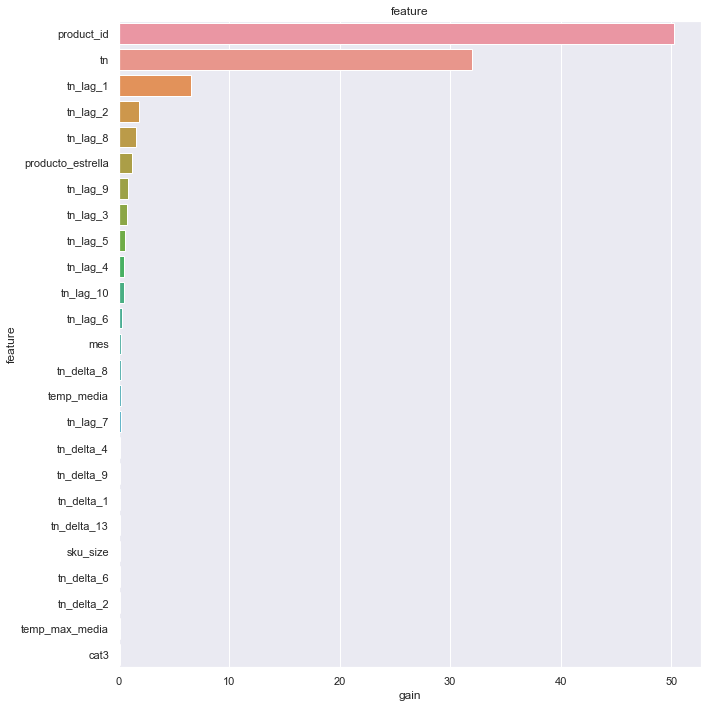

,feature,split,gain
0,product_id,3583,50.21
1,tn,8793,31.93
17,tn_lag_1,6915,6.59
18,tn_lag_2,5043,1.89
24,tn_lag_8,2786,1.62
9,producto_estrella,48,1.26
25,tn_lag_9,2768,0.81
19,tn_lag_3,4418,0.76
21,tn_lag_5,3350,0.57
20,tn_lag_4,4016,0.53


In [32]:
plot_lgb_importances(best_model, num=30, plot=True)

In [33]:
lgbtrain_all = lgb.Dataset(data=X_train_all, label=y_train_all, feature_name=cols)

## Modelo Final

In [34]:
final_model = lgb.train(GLOBAL_PARAMS_ITER[best_model_index], lgbtrain_all, num_boost_round=GLOBAL_BEST_IT_ITER[best_model_index])

In [35]:
GLOBAL_PRODUCT_IDS = actualizar_global_prods(y_holdout_orig)

y_pred_holdout = final_model.predict(X_holdout)
er_holdout = error_rate(y_holdout,y_pred_holdout)
er_holdout

26.1

In [36]:
print(X_holdout.shape)
df_prediccion = X_holdout.copy()
df_prediccion["tn_target"]=np.array(y_holdout_orig)
df_prediccion["tn_predicted"]=np.array(destransformar_vector(y_pred_holdout))
print(df_prediccion.shape)

(868, 47)
(868, 49)


In [37]:
print("Toneladas Holdout:\t", df_prediccion.tn_target.sum())
print("Toneladas Prediccion:\t", df_prediccion.tn_predicted.sum())

Toneladas Holdout:	 33763.86541
Toneladas Prediccion:	 32075.003899498715


In [38]:
df_prediccion = df_prediccion.sort_values(by="product_id",ascending=True)
df_prediccion.to_csv(arch_predicciones_full, index=False)
df_prediccion[["product_id","tn_predicted"]].to_csv(arch_predicciones_simple, index=False)

In [39]:
print("Error Rate Validate:",GLOBAL_ER_VALIDATE_ITER[best_model_index])
print("Error Rate Holdout:",er_holdout)

Error Rate Validate: 21.32
Error Rate Holdout: 26.1


In [40]:
# Armo resultados y calculo modelo final y semillerio para top 5 de error de validacion
df_resultado = pd.DataFrame(data={"error_rate_validation":GLOBAL_ER_VALIDATE_ITER,
                                  "best_iteration": GLOBAL_BEST_IT_ITER,
                                  "params":GLOBAL_PARAMS_ITER})
df_resultado["max_bin"]=MAX_BIN_PARAM

df_resultado = df_resultado.sort_values(by="error_rate_validation",ascending=True)

er_holdout_iter = [None] * len(df_resultado)
er_holdout_semillerio_iter = [None] * len(df_resultado)
for i in range(0,5):
    print("Iteración:",i)
    #Modelo Final (Sin Semillerio)
    final_model = lgb.train(df_resultado.iloc[i].params, lgbtrain_all, num_boost_round=df_resultado.iloc[i].best_iteration)
    y_pred_holdout = final_model.predict(X_holdout)
    er_holdout = error_rate(y_holdout,y_pred_holdout)
    er_holdout_iter[i]=er_holdout
    
    #Semillerio
    er_holdout_semillerio_iter[i]=(semillerio(lgbtrain_all, df_resultado.iloc[i].params, df_resultado.iloc[i].best_iteration, X_holdout, y_holdout))

df_resultado["error_rate_holdout"]=er_holdout_iter    
df_resultado["error_rate_holdout_semillerio"]=er_holdout_semillerio_iter    
    
datetime_string = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M')
df_resultado.to_excel("resultados_opt_bay_"+GLOBAL_TRANSF+"_"+str(CANT_ITERACIONES_OPT_BAY)+"_"+datetime_string+".xlsx",index=False)

Iteración: 0
Iteración: 1
Iteración: 2
Iteración: 3
Iteración: 4


In [41]:
df_resultado

,error_rate_validation,best_iteration,params,max_bin,error_rate_holdout,error_rate_holdout_semillerio
13,21.32,441,"{'objective': 'regression', 'first_metric_only...",1023,26.10,26.04
24,21.37,615,"{'objective': 'regression', 'first_metric_only...",1023,25.71,25.77
22,21.42,515,"{'objective': 'regression', 'first_metric_only...",1023,25.93,25.81
23,21.54,514,"{'objective': 'regression', 'first_metric_only...",1023,25.70,25.84
8,21.54,612,"{'objective': 'regression', 'first_metric_only...",1023,25.87,25.81
25,21.57,664,"{'objective': 'regression', 'first_metric_only...",1023,NaN,NaN
21,21.68,433,"{'objective': 'regression', 'first_metric_only...",1023,NaN,NaN
17,21.72,424,"{'objective': 'regression', 'first_metric_only...",1023,NaN,NaN
14,21.87,518,"{'objective': 'regression', 'first_metric_only...",1023,NaN,NaN
27,22.08,1020,"{'objective': 'regression', 'first_metric_only...",1023,NaN,NaN


In [42]:
duration = 500  # 1000 milliseconds = 1 second
winsound.Beep(2000, duration)